# Transformers may learn to classify in-context by context-adaptive kernel gradient descent

## Training
Here, we provide a script to train the models. In Google Colab T4 GPU it should take around 160 minutes. Due to compute constraints, we provide code for shorter training here, and with higher learning rate---however, this seems to damage the performance for softmax self-attention, especially in the case $d=2$ (as can be seen below).

In [1]:
!pip install equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.6 MB/s eta 0:00:00


In [2]:
import os
import importlib
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

import equinox as eqx
import jax

import jax.numpy as jnp
from copy import deepcopy
from time import time

import main_utils
import opto_ as opto
import samplers
import samplers
import metrics
importlib.reload(metrics)
from metrics import ce, mse
import main
importlib.reload(main)
from main import eval_step, run_with_opts
from additional_models import cqk_cpv_fit, gd
from analyse import analyse2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
SAVE_FOLDER = "/content/drive/MyDrive/icl-MOSS" #TODO Change to your directory

In [ ]:
parser = main_utils.create_parser()
opto.add_args_to_parser(parser)

INIT_SEED=5
MAIN_RUN_ITERS = 40960000
LONG_RUN_ITERS = 409600000

lin_opts = parser.parse_args(
    [
        '--no_embed',
        '--no_unembed',
        '--not_causal',
        '--exclude_query_token',
        '--no_softmax',
        '--balanced_classes_queries',
        '--init_rescale', '0.002',
        '--classification',
        '--pos_embedding_type', 'none',
        '--n_labels', '5',
        '--train_context_len', '100',
        '--X_dim', '13',
        '--eval_context_len', '100',
        '--eval_n_samples', '512',
        '--no_norm',
        '--optimizer', 'adam',
        '--grad_clip_val', '0.001',
        '--depth', '1',
        '--train_iters', str(MAIN_RUN_ITERS),
        '--train_bs', '2048',
        '--eval_every', '204800',
        '--lr', '0.0005',
        '--d_model', '18',
        '--num_heads', '1',
        '--run', 'lin_c100_lr0.0005',
        '--ckpt_every', '2048000',
        '--init_seed', str(INIT_SEED),
        '--base_folder', SAVE_FOLDER,
        '--raw_name',
        '--no_proj_bias'
    ]
)

sfmx_opts = deepcopy(lin_opts)
sfmx_opts.lr = 0.002
sfmx_opts.init_rescale = 0.002
sfmx_opts.no_softmax = False
sfmx_opts.grad_clip_val = 1.0

all_opts = []

X_dim = 2
cont_len = 100
n_labels = 5

all_opts.append(deepcopy(sfmx_opts))
all_opts[-1].run = f'sfmx_xdim_{X_dim}'
all_opts[-1].train_seed = 11
all_opts[-1].init_seed = 8
all_opts[-1].n_labels = n_labels
all_opts[-1].X_dim = X_dim
all_opts[-1].train_context_len = cont_len
all_opts[-1].eval_context_len = cont_len
all_opts[-1].d_model = all_opts[-1].X_dim + all_opts[-1].n_labels
all_opts[-1].lr = 0.005
all_opts[-1].train_iters = MAIN_RUN_ITERS*2

all_opts.append(deepcopy(lin_opts))
all_opts[-1].run = f'lin_xdim_{X_dim}'
all_opts[-1].train_seed = 11
all_opts[-1].init_seed = 8
all_opts[-1].X_dim = X_dim
all_opts[-1].n_labels = n_labels
all_opts[-1].eval_context_len = cont_len
all_opts[-1].train_context_len = cont_len
all_opts[-1].d_model = all_opts[-1].X_dim + all_opts[-1].n_labels
all_opts[-1].train_iters = MAIN_RUN_ITERS
all_opts[-1].lr = 0.0001

X_dim = 3
cont_len = 100
n_labels = 5

all_opts.append(deepcopy(sfmx_opts))
all_opts[-1].run = f'sfmx_xdim_{X_dim}'
all_opts[-1].train_seed = 11
all_opts[-1].init_seed = 8
all_opts[-1].n_labels = n_labels
all_opts[-1].X_dim = X_dim
all_opts[-1].train_context_len = cont_len
all_opts[-1].eval_context_len = cont_len
all_opts[-1].d_model = all_opts[-1].X_dim + all_opts[-1].n_labels
all_opts[-1].lr = 0.001
all_opts[-1].train_iters = MAIN_RUN_ITERS

all_opts.append(deepcopy(lin_opts))
all_opts[-1].run = f'lin_xdim_{X_dim}'
all_opts[-1].train_seed = 11
all_opts[-1].init_seed = 8
all_opts[-1].X_dim = X_dim
all_opts[-1].n_labels = n_labels
all_opts[-1].eval_context_len = cont_len
all_opts[-1].train_context_len = cont_len
all_opts[-1].d_model = all_opts[-1].X_dim + all_opts[-1].n_labels
all_opts[-1].train_iters = MAIN_RUN_ITERS
all_opts[-1].lr = 0.0001

X_dim = 5
cont_len = 100
n_labels = 5

all_opts.append(deepcopy(sfmx_opts))
all_opts[-1].run = f'sfmx_xdim_{X_dim}'
all_opts[-1].train_seed = 11
all_opts[-1].init_seed = 8
all_opts[-1].n_labels = n_labels
all_opts[-1].X_dim = X_dim
all_opts[-1].train_context_len = cont_len
all_opts[-1].eval_context_len = cont_len
all_opts[-1].d_model = all_opts[-1].X_dim + all_opts[-1].n_labels
all_opts[-1].lr = 0.002
all_opts[-1].train_iters = MAIN_RUN_ITERS

all_opts.append(deepcopy(lin_opts))
all_opts[-1].run = f'lin_xdim_{X_dim}'
all_opts[-1].train_seed = 11
all_opts[-1].init_seed = 8
all_opts[-1].X_dim = X_dim
all_opts[-1].n_labels = n_labels
all_opts[-1].eval_context_len = cont_len
all_opts[-1].train_context_len = cont_len
all_opts[-1].d_model = all_opts[-1].X_dim + all_opts[-1].n_labels
all_opts[-1].train_iters = MAIN_RUN_ITERS
all_opts[-1].lr = 0.0001

X_dim = 10
cont_len = 100
n_labels = 5

all_opts.append(deepcopy(sfmx_opts))
all_opts[-1].run = f'sfmx_xdim_{X_dim}'
all_opts[-1].train_seed = 11
all_opts[-1].init_seed = 8
all_opts[-1].n_labels = n_labels
all_opts[-1].X_dim = X_dim
all_opts[-1].train_context_len = cont_len
all_opts[-1].eval_context_len = cont_len
all_opts[-1].d_model = all_opts[-1].X_dim + all_opts[-1].n_labels
all_opts[-1].lr = 0.005
all_opts[-1].train_iters = MAIN_RUN_ITERS

all_opts.append(deepcopy(lin_opts))
all_opts[-1].run = f'lin_xdim_{X_dim}'
all_opts[-1].train_seed = 11
all_opts[-1].init_seed = 8
all_opts[-1].X_dim = X_dim
all_opts[-1].n_labels = n_labels
all_opts[-1].eval_context_len = cont_len
all_opts[-1].train_context_len = cont_len
all_opts[-1].d_model = all_opts[-1].X_dim + all_opts[-1].n_labels
all_opts[-1].train_iters = MAIN_RUN_ITERS
all_opts[-1].lr = 0.0001

start = time()
for opts in all_opts:
    run_with_opts(opts)
print("Total time (min):", (time() - start) / 60)

## Experiments
These are the functions that are used below for reproducing Figures 3, 4 and 5.

In [8]:
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams['lines.linewidth'] = 2

matplotlib.rc('font', size=18)
matplotlib.rc('axes', titlesize=18)
matplotlib.rc('axes', labelsize=18)
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('legend', fontsize=18)
matplotlib.rc('figure', titlesize=18)

In [9]:
base_folder = SAVE_FOLDER

In [10]:
def get_run_defaults(run_dir):
    opts = main_utils.get_opts_from_json_file(f'{run_dir}/config.json')
    model = main_utils.get_model_from_opts(opts)
    fwd_fn = opto.make_fn_from_opts(opts)

    opt_state = main_utils.get_optimizer_from_opts(opts).init(eqx.filter(model, eqx.is_array))

    ckpt_fmt = {'iter': -1,
                'seeds': {'eval_model_seed': jax.random.PRNGKey(0),
                          'train_data_seed': jax.random.PRNGKey(0),
                          'train_model_seed': jax.random.PRNGKey(0)},
                'opt_state': opt_state,
                'model': model}
    return fwd_fn, ckpt_fmt, opts

In [11]:
def get_model(run, i=-1):
    fwd_fn, ckpt_fmt, opts = get_run_defaults(f'{base_folder}/{run}')
    ckpt_fname = sorted(os.listdir(f'{base_folder}/{run}/checkpoints/'))[i]
    ckpt = eqx.tree_deserialise_leaves(f'{base_folder}/{run}/checkpoints/{ckpt_fname}', ckpt_fmt)
    model = ckpt['model']
    loss_fn = ce if opts.classification else mse
    return {'model': model, 'fwd_fn': fwd_fn, 'loss_fn': loss_fn}

In [12]:
def get_eval_data(run):
    _, _, opts = get_run_defaults(f'{base_folder}/{run}')

    eval_seed = jax.random.PRNGKey(opts.eval_seed)
    eval_data_seed, _, eval_model_seed = jax.random.split(eval_seed, 3)
    eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, opts.eval_n_samples, opts.X_dim, opts.eval_noise_scale))
    data = dict()
    data['eval'] = eval_sampler(eval_data_seed)

    return data, eval_model_seed

In [13]:
def plot_attention(run_dir, ckpt_fnames, qk_vmin=-1, qk_vmax=1, ov_vmin=-5, ov_vmax=5, block=0):
    fwd_fn, ckpt_fmt, opts = get_run_defaults(run_dir)
    n = len(ckpt_fnames)

    fig, axs = plt.subplots(2, n, figsize=(4 * n, 4 * 2))

    for i, ckpt_fname in enumerate(ckpt_fnames):

        ckpt = eqx.tree_deserialise_leaves(f'{run_dir}/checkpoints/{ckpt_fname}', ckpt_fmt)
        model = ckpt['model']
        qkv = model.transformer.blocks[block].attn.qkv.weight
        p = model.transformer.blocks[block].attn.proj.weight
        q, k, v = jnp.reshape(qkv, (3, -1, opts.d_model))
        qk = q.transpose() @ k
        pv = p @ v

        qk_img = axs[0,i].imshow(qk, vmin=qk_vmin, vmax=qk_vmax, cmap='coolwarm')
        vp_img = axs[1,i].imshow(pv, vmin=ov_vmin, vmax=ov_vmax, cmap='coolwarm')

    cbar = plt.colorbar(qk_img, ax=axs[0,:], orientation='vertical', fraction=0.02, pad=0.04)
    cbar2 = plt.colorbar(vp_img, ax=axs[1,:], orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Color Intensity')
    cbar2.set_label('Color Intensity')
    plt.show()

In [14]:
def plot_alg_differences(ax, model1, model2, fwd_fn1, fwd_fn2, eval_data, key, colors=['g', 'b', 'c', 'r'], metrics=['loss', 'entr'], act='Softmax', corr_vs_incorr=True):
    metric_names = {'loss': 'Loss', 'p_corr': 'P correct token', 'entr': 'Entropy'}
    out1 = eval_step(model=model1,
                     fwd_fn=fwd_fn1,
                     loss_fn=ce,
                     x=eval_data['examples'],
                     y=eval_data['labels'],
                     key=key,
                     classification=True)
    out2 = eval_step(model=model2,
                     fwd_fn=fwd_fn2,
                     loss_fn=ce,
                     x=eval_data['examples'],
                     y=eval_data['labels'],
                     key=key,
                     classification=True)

    if corr_vs_incorr:
        masks = dict()

        for val1 in [True, False]:
            for val2 in [True, False]:
                masks['TR: {}, GD: {}'.format('Correct' if val1 else 'Incorrect', 'Correct' if val2 else 'Incorrect')] = jnp.logical_and(out1['accs'] == val1,
                                                                                    out2['accs'] == val2)
        for j, metric in enumerate(metrics):
            for i, label in enumerate(masks):
                ax[j].scatter(out1[metric][masks[label]], out2[metric][masks[label]], marker='.', label=label, color=colors[i], s=80)
                ax[j].axvline(jnp.mean(out1[metric]), c='gray', ls='--')
                ax[j].axhline(jnp.mean(out2[metric]), c='gray', ls='--')
                ax[j].set_title(metric_names[metric])
                ax[j].plot([jnp.min(out1[metric]), jnp.max(out1[metric])], [jnp.min(out1[metric]), jnp.max(out1[metric])], c='k', scalex=False, scaley=False, ls='--')

                ax[j].set_xlabel(f'{act} SA')
                ax[j].set_ylabel('GD')

                ax[j].set_box_aspect(1.0)

        handles, labels = ax[-1].get_legend_handles_labels()
        ax[-1].legend(handles, labels, scatterpoints=1, markerscale=2, bbox_to_anchor=(1,1))
    else:
        for j, metric in enumerate(metrics):
            ax[j].scatter(out1[metric], out2[metric], marker='.', s=80)
            ax[j].set_xlabel(f'{act} SA')
            ax[j].set_ylabel('GD')
            ax[j].set_title(metric_names[metric])
            ax[j].set_box_aspect(1.0)
            ax[j].axvline(jnp.mean(out1[metric]), c='gray', ls='--')
            ax[j].axhline(jnp.mean(out2[metric]), c='gray', ls='--')
            ax[j].plot([jnp.min(out1[metric]), jnp.max(out1[metric])], [jnp.min(out1[metric]), jnp.max(out1[metric])], c='k', scalex=False, scaley=False, ls='--')
    plt.show()
    return {k: jnp.sum(v) for k, v in masks.items()} if corr_vs_incorr else {}

In [15]:
def plot_analysis(ax, dots=[], pred_norms=[], norms=[], factor=1):
    n=len(pred_norms)
    ax.plot(jnp.linspace(0,(n-1)*factor, n), pred_norms, label="Preds diff", color="brown")
    if len(norms)==n:
        ax.plot(jnp.linspace(0,(n-1)*factor, n), norms, label="Model diff", color="orange")
    ax.set_xlabel("Training steps")
    ax.set_ylabel("L2 Norm", color="black")
    ax.tick_params(axis="y", labelcolor="black")
    ax.legend(loc="upper left", bbox_to_anchor=(0.1, 0.95))

    if len(dots)==n:
        ax2 = ax.twinx()
        ax2.plot(jnp.linspace(0,(n-1)*factor, n), dots, label="Cos sim", color="green")
        ax2.set_ylabel("Cosine sim", color="black")
        ax2.tick_params(axis="y", labelcolor="black")
        ax2.legend(loc="upper right", bbox_to_anchor=(0.95, 0.5))
    ax.set_box_aspect(0.8)

## Linear transformer
Following are snippets used to generate Figure 4. Again, we note that the runs in Figure 4 were trained for longer and with a smaller learning rate (and with more checkpoints). However, linear self-attention is not really impacted by these changes.

In [ ]:
run1 = 'lin_xdim_2'
m1 = get_model(run1)
model1, fwd_fn1 = m1['model'], m1['fwd_fn']
_, _, opts = get_run_defaults(f'{base_folder}/{run1}')
eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 10000, opts.X_dim, opts.eval_noise_scale))
key = jax.random.PRNGKey(120)
data = eval_sampler(key)

eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 100, opts.X_dim, opts.eval_noise_scale))
eval_data = eval_sampler(jax.random.PRNGKey(110))

comp_data, key = get_eval_data(run1)

model2 = gd(eval_data=data)
fwd_fn2 = gd.fwd_fn

metrics = ['loss', 'p_corr', 'entr']

dots = []
norms = []
pred_norms = []
for i in tqdm(range(0,20,1)):
    m1 = get_model(run1, i)
    model1, fwd_fn1 = m1['model'], m1['fwd_fn']
    dot, norm, pred_norm = analyse2(eval_data, model1, model2, fwd_fn1, fwd_fn2, key=jax.random.PRNGKey(10))
    dots.append(dot)
    norms.append(norm)
    pred_norms.append(pred_norm)

Doing search for optimal learning rate for gradient descent
Found optimal learning rate: 43.7939567565918


100%|██████████| 20/20 [00:03<00:00,  6.65it/s]


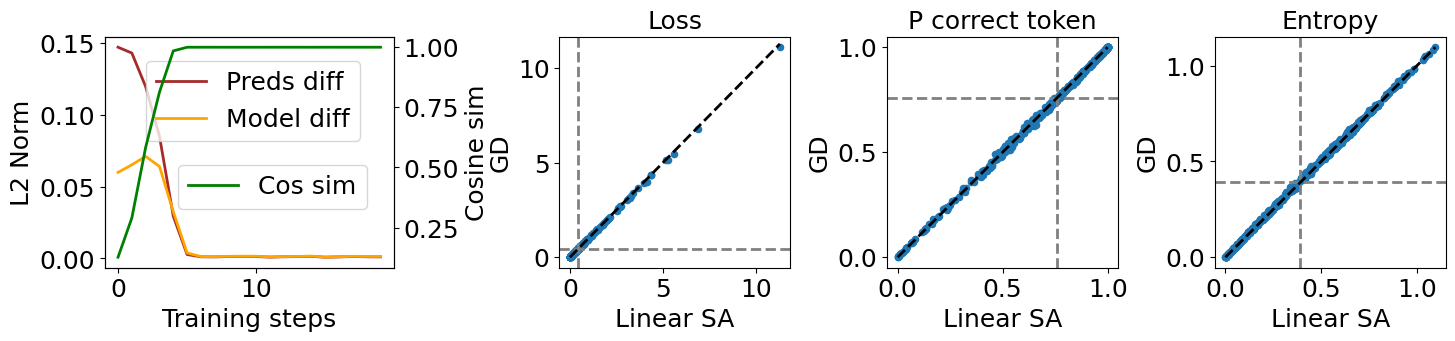

{}

In [ ]:
fig, ax = plt.subplots(
    1, len(metrics) + 1,
    figsize=(7 + 4 * len(metrics), 3),
    gridspec_kw={'width_ratios': [2.5] + [1.5]*len(metrics)}
)
plt.subplots_adjust(wspace=0.1)
plot_analysis(ax[0], dots, pred_norms, norms)
plot_alg_differences(ax[1:], model1, model2, fwd_fn1, fwd_fn2, comp_data['eval'], key, metrics=metrics, act='Linear', corr_vs_incorr=False)

In [ ]:
run1 = 'lin_xdim_3'
m1 = get_model(run1)
model1, fwd_fn1 = m1['model'], m1['fwd_fn']
_, _, opts = get_run_defaults(f'{base_folder}/{run1}')
eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 10000, opts.X_dim, opts.eval_noise_scale))
key = jax.random.PRNGKey(120)
data = eval_sampler(key)

eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 100, opts.X_dim, opts.eval_noise_scale))
eval_data = eval_sampler(jax.random.PRNGKey(110))

comp_data, key = get_eval_data(run1)

model2 = gd(eval_data=data)
fwd_fn2 = gd.fwd_fn

metrics = ['loss', 'p_corr', 'entr']

dots = []
norms = []
pred_norms = []
for i in tqdm(range(0,20,1)):
    m1 = get_model(run1, i)
    model1, fwd_fn1 = m1['model'], m1['fwd_fn']
    dot, norm, pred_norm = analyse2(eval_data, model1, model2, fwd_fn1, fwd_fn2, key=jax.random.PRNGKey(10))
    dots.append(dot)
    norms.append(norm)
    pred_norms.append(pred_norm)

Doing search for optimal learning rate for gradient descent
Found optimal learning rate: 41.32012176513672


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


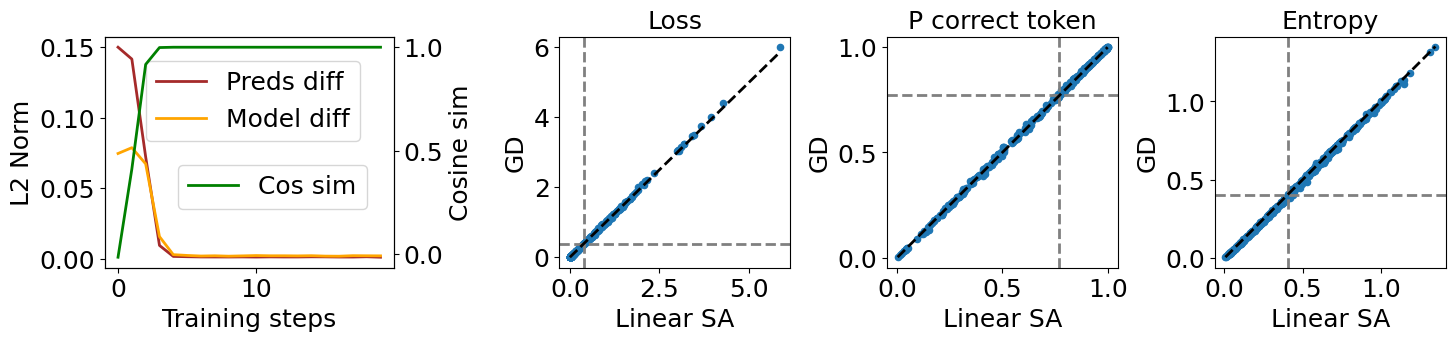

{}

In [ ]:
fig, ax = plt.subplots(
    1, len(metrics) + 1,
    figsize=(7 + 4 * len(metrics), 3),
    gridspec_kw={'width_ratios': [2.5] + [1.5]*len(metrics)}
)
plt.subplots_adjust(wspace=0.1)
plot_analysis(ax[0], dots, pred_norms, norms)
plot_alg_differences(ax[1:], model1, model2, fwd_fn1, fwd_fn2, comp_data['eval'], key, metrics=metrics, act='Linear', corr_vs_incorr=False)

In [ ]:
run1 = 'lin_xdim_5'
m1 = get_model(run1)
model1, fwd_fn1 = m1['model'], m1['fwd_fn']
_, _, opts = get_run_defaults(f'{base_folder}/{run1}')
eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 10000, opts.X_dim, opts.eval_noise_scale))
key = jax.random.PRNGKey(120)
data = eval_sampler(key)

eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 100, opts.X_dim, opts.eval_noise_scale))
eval_data = eval_sampler(jax.random.PRNGKey(110))

comp_data, key = get_eval_data(run1)

model2 = gd(eval_data=data)
fwd_fn2 = gd.fwd_fn

metrics = ['loss', 'p_corr', 'entr']

dots = []
norms = []
pred_norms = []
for i in tqdm(range(0,20,1)):
    m1 = get_model(run1, i)
    model1, fwd_fn1 = m1['model'], m1['fwd_fn']
    dot, norm, pred_norm = analyse2(eval_data, model1, model2, fwd_fn1, fwd_fn2, key=jax.random.PRNGKey(10))
    dots.append(dot)
    norms.append(norm)
    pred_norms.append(pred_norm)

Doing search for optimal learning rate for gradient descent
Found optimal learning rate: 58.5702018737793


100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


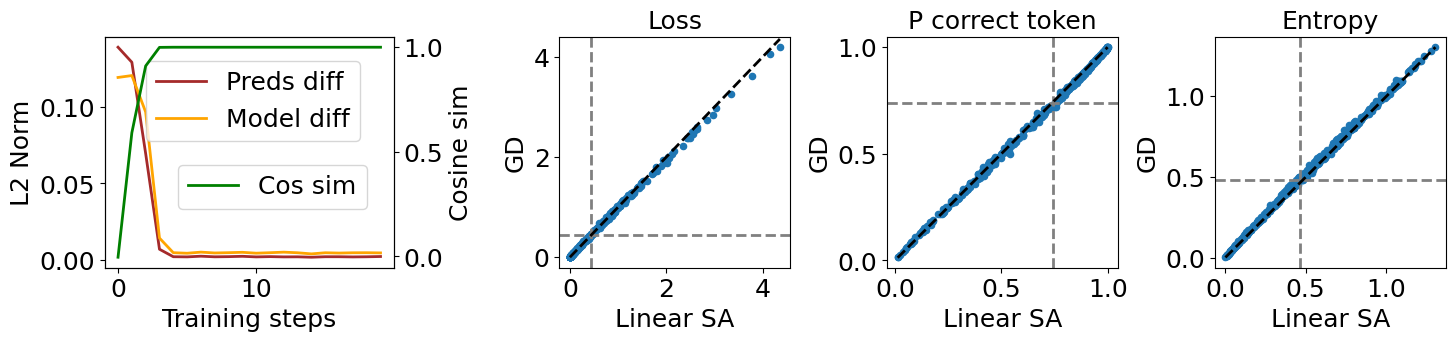

{}

In [ ]:
fig, ax = plt.subplots(
    1, len(metrics) + 1,
    figsize=(7 + 4 * len(metrics), 3),
    gridspec_kw={'width_ratios': [2.5] + [1.5]*len(metrics)}
)
plt.subplots_adjust(wspace=0.1)
plot_analysis(ax[0], dots, pred_norms, norms)
plot_alg_differences(ax[1:], model1, model2, fwd_fn1, fwd_fn2, comp_data['eval'], key, metrics=metrics, act='Linear', corr_vs_incorr=False)

In [ ]:
run1 = 'lin_xdim_10'
m1 = get_model(run1)
model1, fwd_fn1 = m1['model'], m1['fwd_fn']
_, _, opts = get_run_defaults(f'{base_folder}/{run1}')
eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 10000, opts.X_dim, opts.eval_noise_scale))
key = jax.random.PRNGKey(120)
data = eval_sampler(key)

eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 70, opts.X_dim, opts.eval_noise_scale))
eval_data = eval_sampler(jax.random.PRNGKey(110))

comp_data, key = get_eval_data(run1)

model2 = gd(eval_data=data)
fwd_fn2 = gd.fwd_fn

metrics = ['loss', 'p_corr', 'entr']

dots = []
norms = []
pred_norms = []
for i in tqdm(range(0,20,1)):
    m1 = get_model(run1, i)
    model1, fwd_fn1 = m1['model'], m1['fwd_fn']
    dot, norm, pred_norm = analyse2(eval_data, model1, model2, fwd_fn1, fwd_fn2, key=jax.random.PRNGKey(10))
    dots.append(dot)
    norms.append(norm)
    pred_norms.append(pred_norm)

Doing search for optimal learning rate for gradient descent
Found optimal learning rate: 93.26031494140625


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


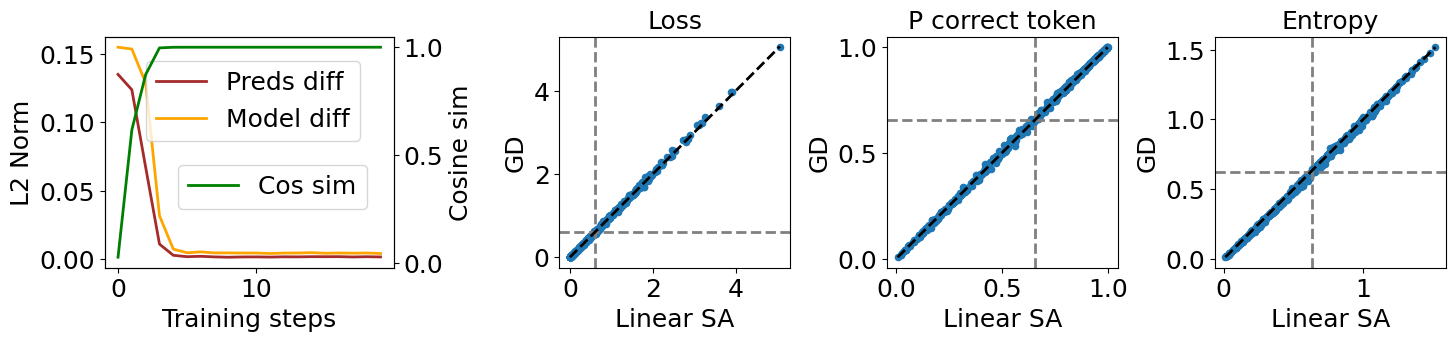

{}

In [ ]:
fig, ax = plt.subplots(
    1, len(metrics) + 1,
    figsize=(7 + 4 * len(metrics), 3),
    gridspec_kw={'width_ratios': [2.5] + [1.5]*len(metrics)}
)
plt.subplots_adjust(wspace=0.1)
plot_analysis(ax[0], dots, pred_norms, norms)
plot_alg_differences(ax[1:], model1, model2, fwd_fn1, fwd_fn2, comp_data['eval'], key, metrics=metrics, act='Linear', corr_vs_incorr=False)

## Softmax transformer
Softmax SA is more impacted by the learning rate in use. We plot the difference metrics for the trained runs, but note that the paper runs were trained for 100 times longer time and with a smaller learning rate (see Appendix G for all the details).

In [20]:
run1 = 'sfmx_xdim_2'
m1 = get_model(run1)
model1, fwd_fn1 = m1['model'], m1['fwd_fn']
_, _, opts = get_run_defaults(f'{base_folder}/{run1}')
eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 10000, opts.X_dim, opts.eval_noise_scale))
key = jax.random.PRNGKey(120)
data = eval_sampler(key)

eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 100, opts.X_dim, opts.eval_noise_scale))
eval_data = eval_sampler(jax.random.PRNGKey(110))

comp_data, key = get_eval_data(run1)

model2 = cqk_cpv_fit(eval_data=data, cqk_low=0, cqk_high=3.5, cpv_low=-1, cpv_high=3) #cqk=cqk, cpv=cpv)
fwd_fn2 = model2.fwd_fn

metrics = ['loss', 'p_corr', 'entr']

dots = []
norms = []
pred_norms = []
for i in tqdm(range(0,40,1)):
    m1 = get_model(run1, i)
    model1, fwd_fn1 = m1['model'], m1['fwd_fn']
    _,_, pred_norm = analyse2(eval_data, model1, model2, fwd_fn1, fwd_fn2, key=jax.random.PRNGKey(10))
    pred_norms.append(pred_norm)

Doing search for optimal cqk and cpv
Found optimal cqk: 932.6029052734375, and optimal cpv: 5.994842529296875


100%|██████████| 40/40 [00:03<00:00, 11.67it/s]


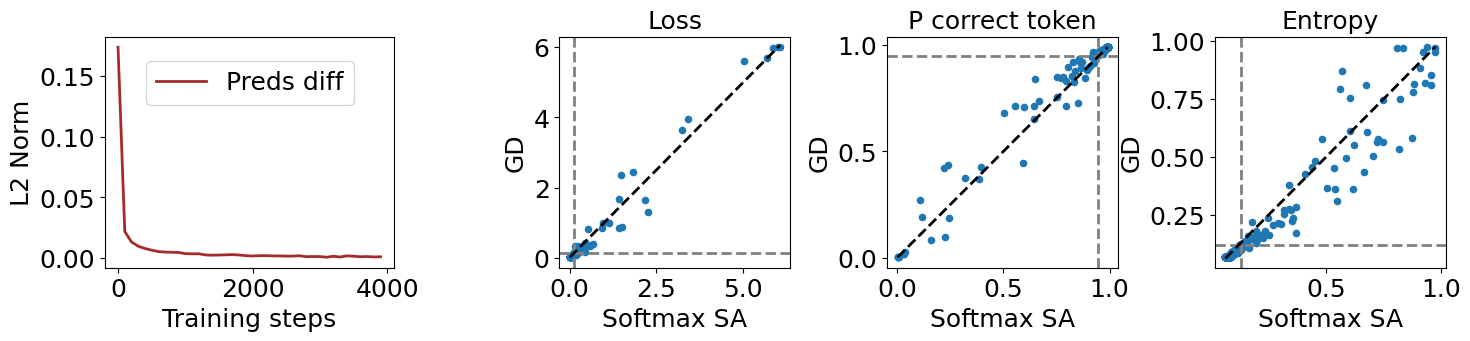

{}

In [21]:
fig, ax = plt.subplots(
    1, len(metrics) + 1,
    figsize=(7 + 4 * len(metrics), 3),
    gridspec_kw={'width_ratios': [2.5] + [1.5]*len(metrics)}
)
plt.subplots_adjust(wspace=0.1)
plot_analysis(ax[0], [], pred_norms, [], factor=100)
plot_alg_differences(ax[1:], model1, model2, fwd_fn1, fwd_fn2, comp_data['eval'], key, metrics=metrics, act='Softmax', corr_vs_incorr=False)

In [18]:
run1 = 'sfmx_xdim_3'
m1 = get_model(run1)
model1, fwd_fn1 = m1['model'], m1['fwd_fn']
_, _, opts = get_run_defaults(f'{base_folder}/{run1}')
eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 10000, opts.X_dim, opts.eval_noise_scale))
key = jax.random.PRNGKey(120)
data = eval_sampler(key)

eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 100, opts.X_dim, opts.eval_noise_scale))
eval_data = eval_sampler(jax.random.PRNGKey(110))

comp_data, key = get_eval_data(run1)

model2 = cqk_cpv_fit(eval_data=data, cqk_low=-1, cqk_high=2, cpv_low=-1, cpv_high=2) #cqk=cqk, cpv=cpv)
fwd_fn2 = model2.fwd_fn

metrics = ['loss', 'p_corr', 'entr']

dots = []
norms = []
pred_norms = []
for i in tqdm(range(0,20,1)):
    m1 = get_model(run1, i)
    model1, fwd_fn1 = m1['model'], m1['fwd_fn']
    dot, norm, pred_norm = analyse2(eval_data, model1, model2, fwd_fn1, fwd_fn2, key=jax.random.PRNGKey(10))
    dots.append(dot)
    norms.append(norm)
    pred_norms.append(pred_norm)

Doing search for optimal cqk and cpv
Found optimal cqk: 35.11192321777344, and optimal cpv: 7.054803848266602


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


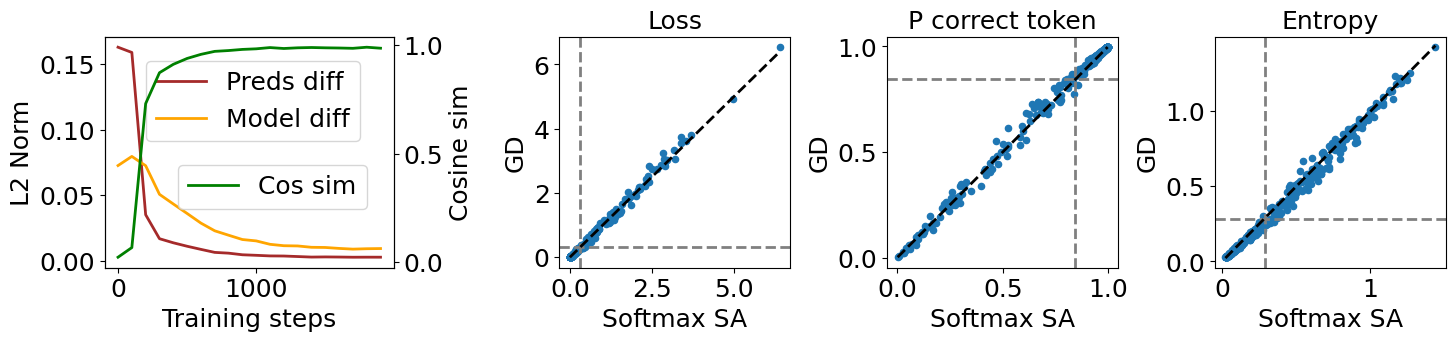

{}

In [19]:
fig, ax = plt.subplots(
    1, len(metrics) + 1,
    figsize=(7 + 4 * len(metrics), 3),
    gridspec_kw={'width_ratios': [2.5] + [1.5]*len(metrics)}  # Give more width to the first plot
)
plt.subplots_adjust(wspace=0.1)
plot_analysis(ax[0], dots, pred_norms, norms, factor=100)
plot_alg_differences(ax[1:], model1, model2, fwd_fn1, fwd_fn2, comp_data['eval'], key, metrics=metrics, act='Softmax', corr_vs_incorr=False)

In [ ]:
run1 = 'sfmx_xdim_5'
m1 = get_model(run1)
model1, fwd_fn1 = m1['model'], m1['fwd_fn']
_, _, opts = get_run_defaults(f'{base_folder}/{run1}')
eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 10000, opts.X_dim, opts.eval_noise_scale))
key = jax.random.PRNGKey(120)
data = eval_sampler(key)

eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 100, opts.X_dim, opts.eval_noise_scale))
eval_data = eval_sampler(jax.random.PRNGKey(110))

comp_data, key = get_eval_data(run1)

model2 = cqk_cpv_fit(eval_data=data, cqk_low=-1, cqk_high=2, cpv_low=-1, cpv_high=2)
fwd_fn2 = model2.fwd_fn

metrics = ['loss', 'p_corr', 'entr']

dots = []
norms = []
pred_norms = []
for i in tqdm(range(0,20,1)):
    m1 = get_model(run1, i)
    model1, fwd_fn1 = m1['model'], m1['fwd_fn']
    dot, norm, pred_norm = analyse2(eval_data, model1, model2, fwd_fn1, fwd_fn2, key=jax.random.PRNGKey(10))
    dots.append(dot)
    norms.append(norm)
    pred_norms.append(pred_norm)

Doing search for optimal cqk and cpv
Found optimal cqk: 3.0538551807403564, and optimal cpv: 57.22367477416992


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


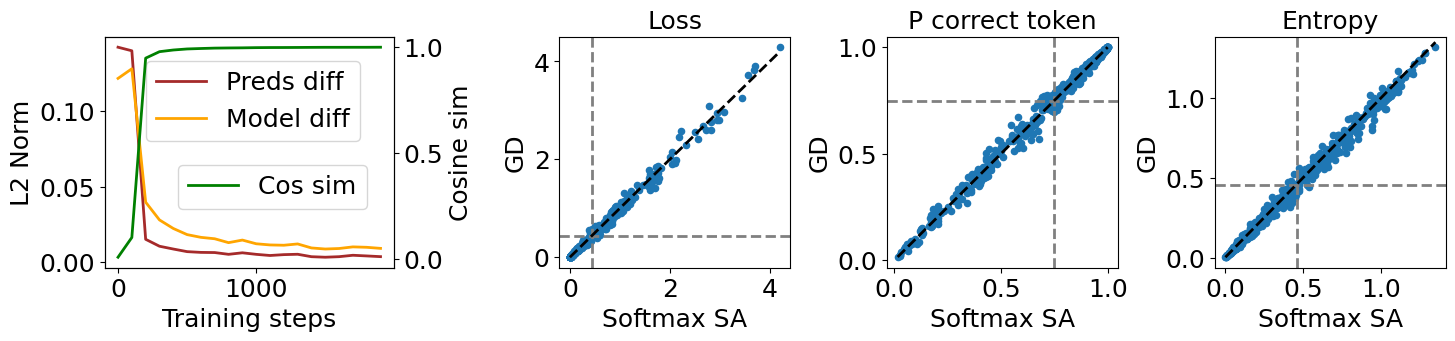

{}

In [ ]:
fig, ax = plt.subplots(
    1, len(metrics) + 1,
    figsize=(7 + 4 * len(metrics), 3),
    gridspec_kw={'width_ratios': [2.5] + [1.5]*len(metrics)}  # Give more width to the first plot
)
plt.subplots_adjust(wspace=0.1)
plot_analysis(ax[0], dots, pred_norms, norms, factor=100)
plot_alg_differences(ax[1:], model1, model2, fwd_fn1, fwd_fn2, comp_data['eval'], key, metrics=metrics, act='Softmax', corr_vs_incorr=False)

For $d=10$ case, what happens here, as well as in all our other experiments in Appendix I, is that the training hasn't converged yet---this suggests a need for a learning rate scheduler.

In [ ]:
run1 = 'sfmx_xdim_10'
m1 = get_model(run1)
model1, fwd_fn1 = m1['model'], m1['fwd_fn']
_, _, opts = get_run_defaults(f'{base_folder}/{run1}')
eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 10000, opts.X_dim, opts.eval_noise_scale))
key = jax.random.PRNGKey(120)
data = eval_sampler(key)

eval_sampler = jax.jit(samplers.make_balanced_classification_queries_sampler(opts.n_labels, opts.eval_context_len, 70, opts.X_dim, opts.eval_noise_scale))
eval_data = eval_sampler(jax.random.PRNGKey(110))

comp_data, key = get_eval_data(run1)

model2 = cqk_cpv_fit(eval_data=data, cqk_low=-3, cqk_high=1, cpv_low=1, cpv_high=4)
fwd_fn2 = model2.fwd_fn

metrics = ['loss', 'p_corr', 'entr']

dots = []
norms = []
pred_norms = []
for i in tqdm(range(0,20,1)):
    m1 = get_model(run1, i)
    model1, fwd_fn1 = m1['model'], m1['fwd_fn']
    dot, norm, pred_norm = analyse2(eval_data, model1, model2, fwd_fn1, fwd_fn2, key=jax.random.PRNGKey(10))
    dots.append(dot)
    norms.append(norm)
    pred_norms.append(pred_norm)

Doing search for optimal cqk and cpv
Found optimal cqk: 0.04534878581762314, and optimal cpv: 8111.31005859375


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


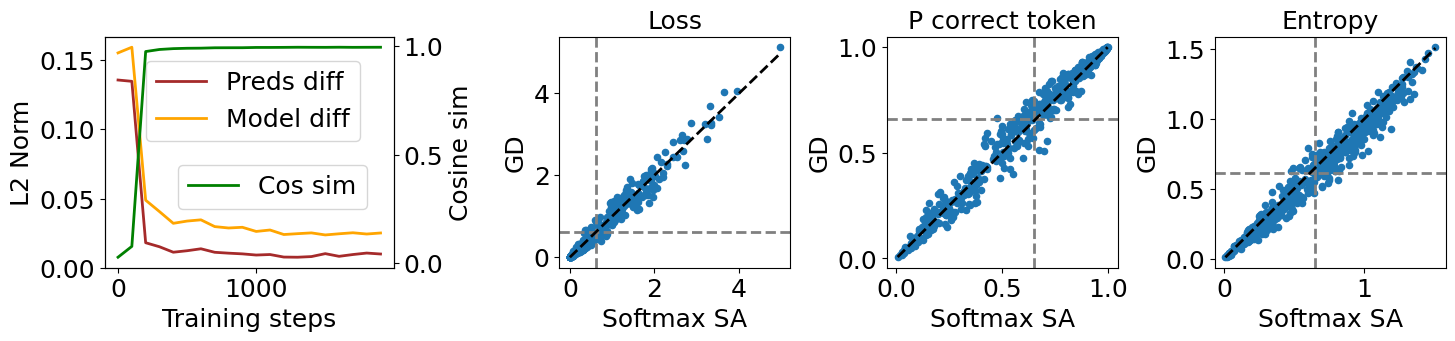

{}

In [ ]:
fig, ax = plt.subplots(
    1, len(metrics) + 1,
    figsize=(7 + 4 * len(metrics), 3),
    gridspec_kw={'width_ratios': [2.5] + [1.5]*len(metrics)}  # Give more width to the first plot
)
plt.subplots_adjust(wspace=0.1)
plot_analysis(ax[0], dots, pred_norms, norms, factor=100)
plot_alg_differences(ax[1:], model1, model2, fwd_fn1, fwd_fn2, comp_data['eval'], key, metrics=metrics, act='Softmax', corr_vs_incorr=False)